In [1]:
from collections import defaultdict

import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE
import xgboost as xgb

In [2]:
WINDOW = 8  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '1y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock

# one day 16 rows of data


In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
    tickers=symbol,

    period=INTERVAL,

    interval=FETCH_INTERVAL,

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by='ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    # auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    prepost=True,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads=False,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy=None
)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-07-27 15:30:00-04:00,94.675003,94.904999,94.629997,94.803749,94.803749,0
2020-07-27 16:00:00-04:00,94.805000,94.975000,94.795000,94.962500,94.962500,0
2020-07-27 17:00:00-04:00,94.810000,94.992500,94.810000,94.985000,94.985000,0
2020-07-27 18:00:00-04:00,94.985000,95.125000,94.957500,95.085000,95.085000,0
2020-07-27 19:00:00-04:00,95.087500,95.247500,95.045000,95.047500,95.047500,0
...,...,...,...,...,...,...
2021-07-27 12:30:00-04:00,146.380005,146.470001,145.718903,145.945007,145.945007,8389728
2021-07-27 13:30:00-04:00,145.925003,146.679993,145.860001,146.664993,146.664993,7438855
2021-07-27 14:30:00-04:00,146.664993,147.320007,146.440002,146.615005,146.615005,11257092


In [4]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)
important_columns = ['open', 'high', 'low', 'close', 'volume']

In [5]:

def calculate_diffs(diff_number, col_name):
    new_col_name = f'{col_name}_{diff_number}'
    data[new_col_name] = data[col_name].diff(diff_number)

In [6]:
# for name in important_columns:
#     for i in range(1, 11):
#         calculate_diffs(i, name)
#
# data.head(10)

In [7]:
data = data.dropna()

<AxesSubplot:xlabel='Datetime'>

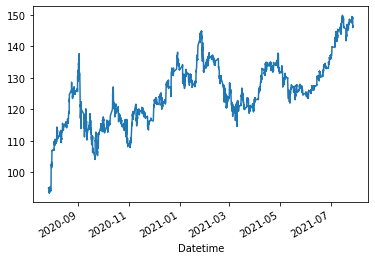

In [8]:
data['close'].plot()

In [9]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-07-27 15:30:00-04:00,94.675003,94.904999,94.629997,94.803749,94.803749,0,NaN
2020-07-27 16:00:00-04:00,94.805000,94.975000,94.795000,94.962500,94.962500,0,0.001675
2020-07-27 17:00:00-04:00,94.810000,94.992500,94.810000,94.985000,94.985000,0,0.000237
2020-07-27 18:00:00-04:00,94.985000,95.125000,94.957500,95.085000,95.085000,0,0.001053
2020-07-27 19:00:00-04:00,95.087500,95.247500,95.045000,95.047500,95.047500,0,-0.000394


In [10]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000,4.191000e+03,4190.000000
mean,125.244864,125.825161,124.527782,125.244412,125.244412,5.564536e+06,0.000117
std,10.104013,11.241192,10.306301,10.105416,10.105416,8.851621e+06,0.005194
min,93.252500,93.477500,58.360000,93.269997,93.269997,0.000000e+00,-0.051319
25%,118.043499,118.565000,117.107499,118.035198,118.035198,0.000000e+00,-0.001697
50%,125.351100,125.840000,124.670000,125.300003,125.300003,0.000000e+00,0.000085
75%,132.145000,132.660000,131.720001,132.156700,132.156700,9.182685e+06,0.002009
max,149.900000,438.440000,149.510000,149.900000,149.900000,9.845401e+07,0.051457


In [11]:
def _get_indicator_data(data):
    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    return data


In [12]:
data

,open,high,low,close,Adj Close,volume,close_pct
Datetime,,,,,,,
2020-07-27 15:30:00-04:00,94.675003,94.904999,94.629997,94.803749,94.803749,0,NaN
2020-07-27 16:00:00-04:00,94.805000,94.975000,94.795000,94.962500,94.962500,0,0.001675
2020-07-27 17:00:00-04:00,94.810000,94.992500,94.810000,94.985000,94.985000,0,0.000237
2020-07-27 18:00:00-04:00,94.985000,95.125000,94.957500,95.085000,95.085000,0,0.001053
2020-07-27 19:00:00-04:00,95.087500,95.247500,95.045000,95.047500,95.047500,0,-0.000394
...,...,...,...,...,...,...,...
2021-07-27 12:30:00-04:00,146.380005,146.470001,145.718903,145.945007,145.945007,8389728,-0.003040
2021-07-27 13:30:00-04:00,145.925003,146.679993,145.860001,146.664993,146.664993,7438855,0.004933
2021-07-27 14:30:00-04:00,146.664993,147.320007,146.440002,146.615005,146.615005,11257092,-0.000341


In [13]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [14]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [15]:
data = _get_indicator_data(data)
data['close_shift'] = data.shift(-WINDOW)['close']
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-27 15:30:00-04:00,94.675003,94.904999,94.629997,94.803749,94.803749,0,NaN,0.000000e+00,0,0.000000,...,0.000000,94.803749,0.000000,0.000000,0.000000,0.000000,-24.305007,0.000000,0.000000,94.625000
2020-07-27 16:00:00-04:00,94.805000,94.975000,94.795000,94.962500,94.962500,0,0.001675,0.000000e+00,0,0.000000,...,0.000000,94.880152,0.000000,0.000000,0.000000,0.000000,0.167452,0.167312,0.167452,94.572500
2020-07-27 17:00:00-04:00,94.810000,94.992500,94.810000,94.985000,94.985000,0,0.000237,0.000000e+00,0,0.000000,...,0.000000,94.927593,0.000000,0.000000,0.000000,0.000000,0.023694,0.023691,0.191185,94.375000
2020-07-27 18:00:00-04:00,94.985000,95.125000,94.957500,95.085000,95.085000,0,0.001053,0.000000e+00,0,0.000000,...,0.000000,94.997069,0.000000,0.000000,0.000000,0.000000,0.105280,0.105224,0.296666,93.680000
2020-07-27 19:00:00-04:00,95.087500,95.247500,95.045000,95.047500,95.047500,0,-0.000394,0.000000e+00,0,0.000000,...,0.000000,95.018962,0.000000,0.000000,0.000000,0.000000,-0.039438,-0.039446,0.257111,93.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27 12:30:00-04:00,146.380005,146.470001,145.718903,145.945007,145.945007,8389728,-0.003040,9.246432e+08,-275542293,-0.157192,...,-1.130783,147.388930,-2.247148,32.495617,3.798693,28.696924,-0.303977,-0.304440,53.944342,NaN
2021-07-27 13:30:00-04:00,145.925003,146.679993,145.860001,146.664993,146.664993,7438855,0.004933,9.318099e+08,-268103438,-0.135439,...,-1.662215,147.313767,-1.764907,29.854762,9.009906,20.844855,0.493327,0.492114,54.703790,NaN
2021-07-27 14:30:00-04:00,146.664993,147.320007,146.440002,146.615005,146.615005,11257092,-0.000341,9.250301e+08,-279360530,-0.142938,...,-1.848552,147.221537,-1.772072,31.313111,13.470547,17.842563,-0.034083,-0.034089,54.651063,NaN


In [16]:
def create_class(df):
    higher_threshold = 1.5
    lowest_threshold = -1.5
    last_values_higher = []
    last_values_lower = []
    df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
    while True:
        class_counts = df['class_column'].value_counts()
        if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
            break

        if len(last_values_higher) == 3:
            last_values_higher.pop(0)
        if len(last_values_lower) == 3:
            last_values_lower.pop(0)

        last_values_higher.append(higher_threshold)
        last_values_lower.append(lowest_threshold)
        if class_counts[0] > class_counts[1]:
            higher_threshold -= 0.01
        if class_counts[0] > class_counts[-1]:
            lowest_threshold += 0.01
        if class_counts[0] < class_counts[1]:
            higher_threshold += 0.01
        if class_counts[0] < class_counts[-1]:
            lowest_threshold -= 0.01

        if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
            break
        df['class_column'] = df.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)),
                                      axis=1)
    print(df['class_column'].value_counts())
    return df


data = create_class(data)

data


 1    1412
-1    1400
 0    1379
Name: class_column, dtype: int64


,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-27 15:30:00-04:00,94.675003,94.904999,94.629997,94.803749,94.803749,0,NaN,0.000000e+00,0,0.000000,...,94.803749,0.000000,0.000000,0.000000,0.000000,-24.305007,0.000000,0.000000,94.625000,0
2020-07-27 16:00:00-04:00,94.805000,94.975000,94.795000,94.962500,94.962500,0,0.001675,0.000000e+00,0,0.000000,...,94.880152,0.000000,0.000000,0.000000,0.000000,0.167452,0.167312,0.167452,94.572500,0
2020-07-27 17:00:00-04:00,94.810000,94.992500,94.810000,94.985000,94.985000,0,0.000237,0.000000e+00,0,0.000000,...,94.927593,0.000000,0.000000,0.000000,0.000000,0.023694,0.023691,0.191185,94.375000,-1
2020-07-27 18:00:00-04:00,94.985000,95.125000,94.957500,95.085000,95.085000,0,0.001053,0.000000e+00,0,0.000000,...,94.997069,0.000000,0.000000,0.000000,0.000000,0.105280,0.105224,0.296666,93.680000,-1
2020-07-27 19:00:00-04:00,95.087500,95.247500,95.045000,95.047500,95.047500,0,-0.000394,0.000000e+00,0,0.000000,...,95.018962,0.000000,0.000000,0.000000,0.000000,-0.039438,-0.039446,0.257111,93.949997,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27 12:30:00-04:00,146.380005,146.470001,145.718903,145.945007,145.945007,8389728,-0.003040,9.246432e+08,-275542293,-0.157192,...,147.388930,-2.247148,32.495617,3.798693,28.696924,-0.303977,-0.304440,53.944342,NaN,0
2021-07-27 13:30:00-04:00,145.925003,146.679993,145.860001,146.664993,146.664993,7438855,0.004933,9.318099e+08,-268103438,-0.135439,...,147.313767,-1.764907,29.854762,9.009906,20.844855,0.493327,0.492114,54.703790,NaN,0
2021-07-27 14:30:00-04:00,146.664993,147.320007,146.440002,146.615005,146.615005,11257092,-0.000341,9.250301e+08,-279360530,-0.142938,...,147.221537,-1.772072,31.313111,13.470547,17.842563,-0.034083,-0.034089,54.651063,NaN,0


In [17]:
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\train_test\\{symbol}_{INTERVAL}_{WINDOW}_diff_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export, index=True)
print(filename_to_export)

C:\Users\exomat\Desktop\repo\magisterka_analiza\data\results\train_test\AAPL_1y_8_diff_27_07_2021 21_50_56_full.csv


In [18]:

# Class divide
data['class_column'].value_counts()

 1    1412
-1    1400
 0    1379
Name: class_column, dtype: int64

In [19]:
# del (data['close'])
# del (data['close_shift'])
data = data.dropna()

In [20]:
data['class_column'].value_counts()


 1    1412
-1    1400
 0    1370
Name: class_column, dtype: int64

In [21]:
def split_dataframe(df, chunk_size=17):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i * chunk_size:(i + 1) * chunk_size])
    return chunks


def train_model(model, train_x, train_y):
    model.fit(train_x, train_y)

In [22]:
splited_dataframe = split_dataframe(data, 17)
len(splited_dataframe)

247

In [23]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column', 'close_shift']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [24]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0, criterion='gini',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=20, random_state=0, criterion='gini',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0, criterion='gini',
                                                                 splitter='random')
classifiers['DecisionTreeClassifier 4'] = DecisionTreeClassifier(max_depth=10, random_state=0, criterion='entropy',
                                                                 splitter='best')
classifiers['DecisionTreeClassifier 5'] = DecisionTreeClassifier(max_depth=15, random_state=0, criterion='entropy',
                                                                 splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,
                                                                 criterion='gini', n_jobs=-1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,
                                                                 criterion='entropy', n_jobs=-1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                         criterion='friedman_mse', max_depth=10,
                                                                         learning_rate=0.3)
classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                         criterion='friedman_mse', max_depth=3,
                                                                         learning_rate=0.1)
classifiers['XGBClassifier 1'] = xgb.XGBClassifier(nthread=-1, max_depth=10, n_estimators=1000, eta=0.2)
classifiers['XGBClassifier 2'] = xgb.XGBClassifier(nthread=-1, max_depth=14, n_estimators=1000, eta=0.3)
classifiers['XGBClassifier 3'] = xgb.XGBClassifier(nthread=-1, max_depth=14, n_estimators=1000, eta=0.2)
classifiers['XGBClassifier 4'] = xgb.XGBClassifier(nthread=-1, max_depth=10, n_estimators=1000, eta=0.5)
classifiers['XGBClassifier 5'] = xgb.XGBClassifier(nthread=-1, max_depth=6, n_estimators=1000, eta=0.3)
classifiers['XGBClassifier 6'] = xgb.XGBClassifier(nthread=-1, max_depth=3, n_estimators=1000, eta=0.3)
classifiers['XGBRFClassifier 1'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=12, n_estimators=100, eta=0.4)
classifiers['XGBRFClassifier 2'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=14, n_estimators=100, eta=0.4)
classifiers['XGBRFClassifier 3'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=3, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 4'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=6, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 5'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=10, n_estimators=1000, eta=0.2)
classifiers['XGBRFClassifier 6'] = xgb.sklearn.XGBRFClassifier(n_jobs=-1, max_depth=10, n_estimators=100, eta=0.4)
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1S'] = GradientBoostingClassifier(n_estimators=100, random_state=0,
                                                                                  criterion='friedman_mse', max_depth=3,
                                                                                  learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2S'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                                  criterion='friedman_mse', max_depth=3,
                                                                                  learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3S'] = GradientBoostingClassifier(n_estimators=1000, random_state=0,
                                                                                  criterion='friedman_mse', max_depth=2,
                                                                                  learning_rate=0.5)
# classifiers_boosted['GradientBoostingClassifier 4S'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)



In [25]:
def count_correct(pred_list, original_list):
    correct_inc = 0
    correct_dec = 0
    correct_stag = 0
    all = len(pred_list)
    all_inc = 0
    all_dec = 0
    all_stag = 0
    for idx, el in enumerate(pred_list):
        if original_list[idx] == 1:
            all_inc += 1
            if el == 1:
                correct_inc += 1
        if original_list[idx] == -1:
            all_dec += 1
            if el == -1:
                correct_dec += 1
        if original_list[idx] == 0:
            all_stag += 1
            if el == 0:
                correct_stag += 1
    return correct_inc, correct_dec, correct_stag, all_inc, all_dec, all_stag, all


In [26]:
print(len(splited_dataframe))

247


In [27]:
start_data = splited_dataframe[:100]
next_data = splited_dataframe[100:105]
print(len(next_data))
score = defaultdict(list)
points = defaultdict(list)
points_train = defaultdict(list)
score_train = defaultdict(list)
step_headers = []
i = 0
print("start")
for idx, day in enumerate(next_data):
    start_data.append(day)
    data_set = pd.concat(start_data)
    data_set = create_class(data_set)
    print(data_set['class_column'].value_counts())
    y = data_set['class_column']
    features = [x for x in data_set.columns if x not in ['class_column']]
    x = data_set[features]
    x_train = x.iloc[:-17]
    y_train = y.iloc[:-17]
    x_test = x.iloc[-17:]
    y_test = y.iloc[-17:]

    print(len(data_set))

    step_headers.append(f'<{i}>')
    i = i + 1
    predictions_train = dict()
    predictions = dict()

    for k, v in classifiers.items():
        print("Calculate: ", k)
        train_model(v, x_train, y_train)
        predictions_train[k] = v.predict(x_train)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k], y_train.values))
        points[k].append(count_correct(predictions[k], y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))

    rfe = RFE(classifiers['RandomForestClassifier 5'], 10)
    fited = rfe.fit(x_train, y_train)
    names = x.columns
    columns = []
    for i in range(len(fited.support_)):
        if fited.support_[i]:
            columns.append(names[i])

    print("Columns with predictive power:", columns)
    columns = columns + ['high', 'low', 'volume', 'open']
    x_test_cropped = x_test[columns]
    x_train_cropped = x_train[columns]
    for k, v in classifiers_boosted.items():
        print("Calculate: ", k)
        train_model(v, x_train_cropped, y_train)
        predictions_train[k] = v.predict(x_train_cropped)
        score_train[k].append(accuracy_score(y_train.values, predictions_train[k]))
        predictions[k] = v.predict(x_test_cropped)
        score[k].append(accuracy_score(y_test.values, predictions[k]))
        points_train[k].append(count_correct(predictions_train[k], y_train.values))
        points[k].append(count_correct(predictions[k], y_test.values))
        print(accuracy_score(y_test.values, predictions[k]))




5
start
 1    582
 0    573
-1    562
Name: class_column, dtype: int64
 1    582
 0    573
-1    562
Name: class_column, dtype: int64
1717
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.17647058823529413
Calculate:  DecisionTreeClassifier 5
0.17647058823529413
Calculate:  RandomForestClassifier 4
0.17647058823529413
Calculate:  RandomForestClassifier 5
0.17647058823529413
Calculate:  GradientBoostingClassifier 1
0.8823529411764706
Calculate:  GradientBoostingClassifier 2
0.7647058823529411
Calculate:  GradientBoostingClassifier 3
0.8235294117647058
Calculate:  XGBClassifier 1
[21:52:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9411764705882353
Calculate:  XGBClassifier 2
[21:52:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9411764705882353
Calculate:  XGBClassifier 3
[21:53:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8823529411764706
Calculate:  XGBClassifier 4
[21:53:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kch', 'volatility_kcw', 'volatility_dcw', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_psar_down', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.9411764705882353
Calculate:  GradientBoostingClassifier 2S
1.0
Calculate:  GradientBoostingClassifier 3S
1.0
 1    588
 0    576
-1    570
Name: class_column, dtype: int64
 1    588
 0    576
-1    570
Name: class_column, dtype: int64
1734
Calculate:  DecisionTreeClassifier 1
0.058823529411764705
Calculate:  DecisionTreeClassifier 2
0.058823529411764705
Calculate:  DecisionTreeClassifier 3
0.11764705882352941
Calculate:  DecisionTreeClassifier 4
0.058823529411764705
Calculate:  DecisionTreeClassifier 5
0.058823529411764705
Calculate:  RandomForestClassifier 4
0.058823529411764705
Calculate:  RandomForestClassifier 5
0.058823529411764705
Calculate:  GradientBoostingClassifier 1
0.058823529411764705
Calculate:  GradientBoo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.058823529411764705
Calculate:  XGBClassifier 2
[21:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.058823529411764705
Calculate:  XGBClassifier 3
[21:56:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.058823529411764705
Calculate:  XGBClassifier 4
[21:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'm

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_sma_slow', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_psar_down', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.058823529411764705
Calculate:  GradientBoostingClassifier 2S
0.058823529411764705
Calculate:  GradientBoostingClassifier 3S
0.058823529411764705
 1    591
 0    581
-1    579
Name: class_column, dtype: int64
 1    591
 0    581
-1    579
Name: class_column, dtype: int64
1751
Calculate:  DecisionTreeClassifier 1
0.6470588235294118
Calculate:  DecisionTreeClassifier 2
0.5882352941176471
Calculate:  DecisionTreeClassifier 3
0.4117647058823529
Calculate:  DecisionTreeClassifier 4
0.29411764705882354
Calculate:  DecisionTreeClassifier 5
0.29411764705882354
Calculate:  RandomForestClassifier 4
0.5882352941176471
Calculate:  RandomForestClassifier 5
0.4117647058823529
Calculate:  GradientBoostingClassifier 1
0.5294117647058824


C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.35294117647058826
Calculate:  XGBClassifier 2
[22:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 3
[22:00:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.4117647058823529
Calculate:  XGBClassifier 4
[22:00:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglo

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbh', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_ichimoku_conv', 'trend_ichimoku_b', 'trend_psar_down', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.47058823529411764
Calculate:  GradientBoostingClassifier 3S
0.5294117647058824
 1    601
-1    585
 0    582
Name: class_column, dtype: int64
 1    601
-1    585
 0    582
Name: class_column, dtype: int64
1768
Calculate:  DecisionTreeClassifier 1
0.0
Calculate:  DecisionTreeClassifier 2
0.11764705882352941
Calculate:  DecisionTreeClassifier 3
0.35294117647058826
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.5294117647058824
Calculate:  RandomForestClassifier 4
0.0
Calculate:  RandomForestClassifier 5
0.0
Calculate:  GradientBoostingClassifier 1
0.9411764705882353
Calculate:  GradientBoostingClassifier 2
0.2941176470588235

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7647058823529411
Calculate:  XGBClassifier 2
[22:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 3
[22:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6470588235294118
Calculate:  XGBClassifier 4
[22:03:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_sma_slow', 'trend_ichimoku_a', 'trend_psar_down', 'momentum_kama', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.9411764705882353
Calculate:  GradientBoostingClassifier 2S
0.8235294117647058
Calculate:  GradientBoostingClassifier 3S
0.7058823529411765
 1    602
-1    592
 0    591
Name: class_column, dtype: int64
 1    602
-1    592
 0    591
Name: class_column, dtype: int64
1785
Calculate:  DecisionTreeClassifier 1
0.29411764705882354
Calculate:  DecisionTreeClassifier 2
0.47058823529411764
Calculate:  DecisionTreeClassifier 3
0.47058823529411764
Calculate:  DecisionTreeClassifier 4
0.47058823529411764
Calculate:  DecisionTreeClassifier 5
0.47058823529411764
Calculate:  RandomForestClassifier 4
0.47058823529411764
Calculate:  RandomForestClassifier 5
0.6470588235294118
Calculate:  GradientBoostingClassifier 1
0.5294117647058824
Calculate:  Gradien

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5294117647058824
Calculate:  XGBClassifier 2
[22:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 3
[22:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5882352941176471
Calculate:  XGBClassifier 4
[22:07:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mloglos

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Columns with predictive power: ['volatility_atr', 'volatility_bbw', 'volatility_kcw', 'volatility_dcw', 'trend_sma_slow', 'trend_ichimoku_conv', 'trend_psar_down', 'momentum_kama', 'momentum_ppo', 'close_shift']
Calculate:  GradientBoostingClassifier 1S
0.47058823529411764
Calculate:  GradientBoostingClassifier 2S
0.47058823529411764
Calculate:  GradientBoostingClassifier 3S
0.47058823529411764


In [28]:
headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type", ] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index=score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
f_out.to_csv(filename_to_export, index=False)

+----+-------------------------------+----------+-----------+----------+----------+----------+----------+
|    | Classifier type               |      <0> |      <90> |     <90> |     <90> |     <90> |     mean |
|----+-------------------------------+----------+-----------+----------+----------+----------+----------|
|  0 | DecisionTreeClassifier 1      | 0.294118 | 0.0588235 | 0.647059 | 0        | 0.294118 | 0.258824 |
|  1 | DecisionTreeClassifier 2      | 0.117647 | 0.0588235 | 0.588235 | 0.117647 | 0.470588 | 0.270588 |
|  2 | DecisionTreeClassifier 3      | 0.411765 | 0.117647  | 0.411765 | 0.352941 | 0.470588 | 0.352941 |
|  3 | DecisionTreeClassifier 4      | 0.176471 | 0.0588235 | 0.294118 | 0.470588 | 0.470588 | 0.294118 |
|  4 | DecisionTreeClassifier 5      | 0.176471 | 0.0588235 | 0.294118 | 0.529412 | 0.470588 | 0.305882 |
|  5 | RandomForestClassifier 4      | 0.176471 | 0.0588235 | 0.588235 | 0        | 0.470588 | 0.258824 |
|  6 | RandomForestClassifier 5      | 0.17647

In [29]:
score_train

defaultdict(list,
            {'DecisionTreeClassifier 1': [0.8994117647058824,
              0.9056493884682586,
              0.8800461361014994,
              0.8520845231296402,
              0.8054298642533937],
             'DecisionTreeClassifier 2': [0.9994117647058823,
              0.9988351776354106,
              1.0,
              0.9902912621359223,
              0.9932126696832579],
             'DecisionTreeClassifier 3': [0.7964705882352942,
              0.8683750728013978,
              0.8391003460207612,
              0.8280982295830954,
              0.8438914027149321],
             'DecisionTreeClassifier 4': [0.9358823529411765,
              0.8648806057076296,
              0.8662053056516724,
              0.8920616790405482,
              0.8636877828054299],
             'DecisionTreeClassifier 5': [0.9970588235294118,
              0.9976703552708212,
              0.9844290657439446,
              0.9937178754997145,
              0.9751131221719457],
  

In [30]:
# print(tabulate(score_df, headers, tablefmt="psql"))
headers = ["Classifier type", "Accuracy"]
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
headers2 = ["Classifier type", ] + step_headers
score_df_train = pd.DataFrame(score_train.items(), columns=headers)
accuracy_df_train = pd.DataFrame(score_df_train['Accuracy'].tolist(), index=score_df_train.index, columns=step_headers)
score_df_train = score_df_train.drop('Accuracy', 1)
f_out_train = pd.merge(score_df_train, accuracy_df_train, how='left', left_index=True, right_index=True)
f_out_train['mean'] = f_out_train.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out_train, headers2, tablefmt="psql"))

filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_test_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_train_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

f_out_train.to_csv(filename_to_export_train, index=False)

+----+-------------------------------+----------+----------+----------+----------+----------+----------+
|    | Classifier type               |      <0> |     <90> |     <90> |     <90> |     <90> |     mean |
|----+-------------------------------+----------+----------+----------+----------+----------+----------|
|  0 | DecisionTreeClassifier 1      | 0.899412 | 0.905649 | 0.880046 | 0.852085 | 0.80543  | 0.868524 |
|  1 | DecisionTreeClassifier 2      | 0.999412 | 0.998835 | 1        | 0.990291 | 0.993213 | 0.99635  |
|  2 | DecisionTreeClassifier 3      | 0.796471 | 0.868375 | 0.8391   | 0.828098 | 0.843891 | 0.835187 |
|  3 | DecisionTreeClassifier 4      | 0.935882 | 0.864881 | 0.866205 | 0.892062 | 0.863688 | 0.884544 |
|  4 | DecisionTreeClassifier 5      | 0.997059 | 0.99767  | 0.984429 | 0.993718 | 0.975113 | 0.989598 |
|  5 | RandomForestClassifier 4      | 0.599412 | 0.617938 | 0.627451 | 0.625928 | 0.638575 | 0.621861 |
|  6 | RandomForestClassifier 5      | 0.530588 | 0.538

In [31]:
filename_to_export_train = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result_train_points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
filename_to_export = f'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\results\\nfold\\result__points_{symbol}_{WINDOW}_{datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'

points
df_points = pd.DataFrame(points.items())
df_temp = pd.DataFrame(df_points[1].tolist(), index=score_df_train.index)
df_points = df_points.drop(df_points.columns[1], axis=1)
df_points = pd.merge(df_points, df_temp, how='left', left_index=True, right_index=True)
df_points.to_csv(filename_to_export)
df_points

# df_points_train = pd(points_train.items())

,0_x,0_y,1,2,3,4
0,DecisionTreeClassifier 1,"(3, 2, 0, 14, 3, 0, 17)","(0, 0, 1, 1, 1, 15, 17)","(0, 9, 2, 3, 9, 5, 17)","(0, 0, 0, 15, 0, 2, 17)","(1, 2, 2, 8, 7, 2, 17)"
1,DecisionTreeClassifier 2,"(0, 2, 0, 14, 3, 0, 17)","(0, 0, 1, 1, 1, 15, 17)","(0, 9, 1, 3, 9, 5, 17)","(2, 0, 0, 15, 0, 2, 17)","(1, 7, 0, 8, 7, 2, 17)"
2,DecisionTreeClassifier 3,"(4, 3, 0, 14, 3, 0, 17)","(1, 1, 0, 1, 1, 15, 17)","(1, 2, 4, 3, 9, 5, 17)","(6, 0, 0, 15, 0, 2, 17)","(1, 7, 0, 8, 7, 2, 17)"
3,DecisionTreeClassifier 4,"(0, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(0, 0, 5, 3, 9, 5, 17)","(7, 0, 1, 15, 0, 2, 17)","(8, 0, 0, 8, 7, 2, 17)"
4,DecisionTreeClassifier 5,"(0, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(0, 0, 5, 3, 9, 5, 17)","(7, 0, 2, 15, 0, 2, 17)","(8, 0, 0, 8, 7, 2, 17)"
5,RandomForestClassifier 4,"(0, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(0, 9, 1, 3, 9, 5, 17)","(0, 0, 0, 15, 0, 2, 17)","(1, 7, 0, 8, 7, 2, 17)"
6,RandomForestClassifier 5,"(0, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(0, 5, 2, 3, 9, 5, 17)","(0, 0, 0, 15, 0, 2, 17)","(4, 7, 0, 8, 7, 2, 17)"
7,GradientBoostingClassifier 1,"(12, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(3, 2, 4, 3, 9, 5, 17)","(15, 0, 1, 15, 0, 2, 17)","(2, 7, 0, 8, 7, 2, 17)"
8,GradientBoostingClassifier 2,"(10, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(1, 3, 4, 3, 9, 5, 17)","(5, 0, 0, 15, 0, 2, 17)","(8, 0, 0, 8, 7, 2, 17)"
9,GradientBoostingClassifier 3,"(11, 3, 0, 14, 3, 0, 17)","(1, 0, 0, 1, 1, 15, 17)","(3, 3, 3, 3, 9, 5, 17)","(10, 0, 0, 15, 0, 2, 17)","(7, 7, 0, 8, 7, 2, 17)"


In [32]:
df_points_train = pd.DataFrame(points_train.items())
df_temp = pd.DataFrame(df_points_train[1].tolist(), index=score_df_train.index)
df_points_train = df_points.drop(df_points_train.columns[1], axis=1)
df_points_train = pd.merge(df_points_train, df_temp, how='left', left_index=True, right_index=True)
df_points_train.to_csv(filename_to_export_train)
df_points_train

,0_x,0_y,2_x,3_x,4_x,0,1,2_y,3_y,4_y
0,DecisionTreeClassifier 1,"(3, 2, 0, 14, 3, 0, 17)","(0, 9, 2, 3, 9, 5, 17)","(0, 0, 0, 15, 0, 2, 17)","(1, 2, 2, 8, 7, 2, 17)","(503, 489, 537, 568, 559, 573, 1700)","(524, 540, 491, 587, 569, 561, 1717)","(509, 483, 534, 588, 570, 576, 1734)","(466, 501, 525, 586, 585, 580, 1751)","(455, 400, 569, 594, 585, 589, 1768)"
1,DecisionTreeClassifier 2,"(0, 2, 0, 14, 3, 0, 17)","(0, 9, 1, 3, 9, 5, 17)","(2, 0, 0, 15, 0, 2, 17)","(1, 7, 0, 8, 7, 2, 17)","(567, 559, 573, 568, 559, 573, 1700)","(587, 568, 560, 587, 569, 561, 1717)","(588, 570, 576, 588, 570, 576, 1734)","(576, 580, 578, 586, 585, 580, 1751)","(590, 581, 585, 594, 585, 589, 1768)"
2,DecisionTreeClassifier 3,"(4, 3, 0, 14, 3, 0, 17)","(1, 2, 4, 3, 9, 5, 17)","(6, 0, 0, 15, 0, 2, 17)","(1, 7, 0, 8, 7, 2, 17)","(436, 421, 497, 568, 559, 573, 1700)","(539, 497, 455, 587, 569, 561, 1717)","(464, 498, 493, 588, 570, 576, 1734)","(498, 464, 488, 586, 585, 580, 1751)","(492, 496, 504, 594, 585, 589, 1768)"
3,DecisionTreeClassifier 4,"(0, 3, 0, 14, 3, 0, 17)","(0, 0, 5, 3, 9, 5, 17)","(7, 0, 1, 15, 0, 2, 17)","(8, 0, 0, 8, 7, 2, 17)","(534, 535, 522, 568, 559, 573, 1700)","(501, 526, 458, 587, 569, 561, 1717)","(489, 542, 471, 588, 570, 576, 1734)","(561, 558, 443, 586, 585, 580, 1751)","(497, 487, 543, 594, 585, 589, 1768)"
4,DecisionTreeClassifier 5,"(0, 3, 0, 14, 3, 0, 17)","(0, 0, 5, 3, 9, 5, 17)","(7, 0, 2, 15, 0, 2, 17)","(8, 0, 0, 8, 7, 2, 17)","(566, 558, 571, 568, 559, 573, 1700)","(587, 568, 558, 587, 569, 561, 1717)","(577, 561, 569, 588, 570, 576, 1734)","(584, 583, 573, 586, 585, 580, 1751)","(564, 575, 585, 594, 585, 589, 1768)"
5,RandomForestClassifier 4,"(0, 3, 0, 14, 3, 0, 17)","(0, 9, 1, 3, 9, 5, 17)","(0, 0, 0, 15, 0, 2, 17)","(1, 7, 0, 8, 7, 2, 17)","(351, 290, 378, 568, 559, 573, 1700)","(385, 333, 343, 587, 569, 561, 1717)","(387, 330, 371, 588, 570, 576, 1734)","(375, 356, 365, 586, 585, 580, 1751)","(393, 353, 383, 594, 585, 589, 1768)"
6,RandomForestClassifier 5,"(0, 3, 0, 14, 3, 0, 17)","(0, 5, 2, 3, 9, 5, 17)","(0, 0, 0, 15, 0, 2, 17)","(4, 7, 0, 8, 7, 2, 17)","(340, 209, 353, 568, 559, 573, 1700)","(385, 209, 330, 587, 569, 561, 1717)","(368, 201, 338, 588, 570, 576, 1734)","(328, 276, 327, 586, 585, 580, 1751)","(347, 235, 347, 594, 585, 589, 1768)"
7,GradientBoostingClassifier 1,"(12, 3, 0, 14, 3, 0, 17)","(3, 2, 4, 3, 9, 5, 17)","(15, 0, 1, 15, 0, 2, 17)","(2, 7, 0, 8, 7, 2, 17)","(549, 553, 563, 568, 559, 573, 1700)","(569, 560, 543, 587, 569, 561, 1717)","(567, 558, 556, 588, 570, 576, 1734)","(563, 574, 557, 586, 585, 580, 1751)","(574, 576, 568, 594, 585, 589, 1768)"
8,GradientBoostingClassifier 2,"(10, 3, 0, 14, 3, 0, 17)","(1, 3, 4, 3, 9, 5, 17)","(5, 0, 0, 15, 0, 2, 17)","(8, 0, 0, 8, 7, 2, 17)","(568, 559, 573, 568, 559, 573, 1700)","(587, 569, 561, 587, 569, 561, 1717)","(588, 570, 576, 588, 570, 576, 1734)","(586, 585, 580, 586, 585, 580, 1751)","(594, 585, 589, 594, 585, 589, 1768)"
9,GradientBoostingClassifier 3,"(11, 3, 0, 14, 3, 0, 17)","(3, 3, 3, 3, 9, 5, 17)","(10, 0, 0, 15, 0, 2, 17)","(7, 7, 0, 8, 7, 2, 17)","(568, 559, 573, 568, 559, 573, 1700)","(587, 569, 561, 587, 569, 561, 1717)","(588, 570, 576, 588, 570, 576, 1734)","(586, 585, 580, 586, 585, 580, 1751)","(594, 585, 589, 594, 585, 589, 1768)"


In [33]:
import csv

with open("test_points.csv", "wr") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(points.keys())
   writer.writerows(zip(*points.values()))

TypeError: a bytes-like object is required, not 'str'

In [ ]:
with open("test_points_train.csv", "wr")  as outfile:
   writer = csv.writer(outfile)
   writer.writerow(points_train.keys())
   writer.writerows(zip(*points_train.values()))